In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import pandas as pd
import json
import seaborn as sns

In [3]:
df=pd.read_csv("df.csv")
path = "../figs/"
saving = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

def analyse_single(d,x,y,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=False, with_stats=False,saving=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.violinplot(x=x, y=y, data=d, split=False, inner=None, palette=palette,ax=ax1)
    sns.swarmplot(x=x, y=y, data=d, dodge=True, palette=["black", "black","black"],ax=ax1)

    ma=max(d[y].values)
    mi=min(d[y].values)
    if mi > 0 and mi < .2*ma:
        ax1.set_ylim(0,1.1*ma)
        ax2.set_ylim(0,1.1*ma)
    else:
        ax1.set_ylim(mi-.05*ma,1.05*ma)
        ax2.set_ylim(mi-.05*ma,1.05*ma)
    
    ax1.set_xlabel(xlabel, **font)
    ax1.set_ylabel("", **font)
    sns.pointplot(x=x, y=y, data=d, palette=palette,ax=ax2)
    #ax2.set_yticklabels(ax1.get_yticklabels())
    ax2.set_xlabel(xlabel, **font)
    ax2.set_ylabel(ylabel+"\n", **font)
    ax2.yaxis.tick_right()
    
    if legend:
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        l = ax2.legend(handles1[0:3], labels2[0:3], loc='upper left',prop={'size': 13})
        ax1.legend_.remove()
    if saving:
        f.savefig(path+y+".pdf",bbox_inches="tight")
    if with_stats:
        l=list(set(d[x].tolist()))
        v=[]
        for i in l:                
            v.append(d.loc[d[x]==i][y].tolist())
            
        print "anova:"
        print stats.f_oneway(v[0],v[1],v[2])
        for i,a in enumerate(v):
            for j,b in enumerate(v):
                if j>i:
                    print l[i]+"-"+l[j]+":"
                    print stats.ttest_ind(a,b)
                    
def expend_frame(data,x,y,hue):
    col = [l for l in list(data) if y in l]
    d={x:[],y:[],hue:[]}
    for i,c in enumerate(col):
        d[x]=d[x]+ [str(i+1)] * len(data)
        d[y]=d[y]+data[c].tolist()
        d[hue]=d[hue]+data[hue].tolist()
    return pd.DataFrame(d)

def plot(d,x,y,hue,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=True,saving=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.violinplot(x=x, y=y, hue=hue, data=d, split=False, inner=None, palette=palette,ax=ax1)
    sns.swarmplot(x=x, y=y, hue=hue, data=d, dodge=True, palette=["black", "black","black"],ax=ax1)

    ma=max(d[y].values)
    mi=min(d[y].values)
    if mi > 0 and mi < .2*ma:
        ax1.set_ylim(0,1.1*ma)
        ax2.set_ylim(0,1.1*ma)
    else:
        ax1.set_ylim(mi-.05*ma,1.05*ma)
        ax2.set_ylim(mi-.05*ma,1.05*ma)
    
    ax1.set_xlabel(xlabel, **font)
    ax1.set_ylabel("", **font)
    sns.pointplot(x=x, y=y, hue=hue, data=d, palette=palette,ax=ax2)
    #ax2.set_yticklabels(ax1.get_yticklabels())
    ax2.set_xlabel(xlabel, **font)
    ax2.set_ylabel(ylabel+"\n", **font)
    ax2.yaxis.tick_right()
    
    if legend:
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        l = ax2.legend(handles1[0:3], labels2[0:3], loc='upper left',prop={'size': 13})
        ax1.legend_.remove()
    if saving:
        f.savefig(path+y+".pdf",bbox_inches="tight")
    plt.show()    

def analyse(data,x,y,hue,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=True,saving=False):
    d=expend_frame(data,x,y,hue)
    plot(d,x,y,hue,xlabel,ylabel,palette,legend,saving)
    
def analyse_actions(data,cat,hue,xlabel,ylabel,action_labels,palette=["#F7C544", "#0AB234"],legend=True,saving=False):
    x="action"
    y="number"
    d={x:[],y:[],hue:[]}
    for i,c in enumerate(cat):
        d[x]=d[x]+ [c] * len(data)
        d[y]=d[y]+data[c].tolist()
        d[hue]=d[hue]+data[hue].tolist()
    d=pd.DataFrame(d)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.violinplot(x=x, y=y, hue=hue, data=d, split=False, inner=None, palette=palette,ax=ax1)
    sns.swarmplot(x=x, y=y, hue=hue, data=d, dodge=True, palette=["black", "black","black"],ax=ax1)
    
    ma=max(d[y].values)
    mi=min(d[y].values)
    if mi > 0 and mi < .2*ma:
        ax1.set_ylim(0,1.1*ma)
        ax2.set_ylim(0,1.1*ma)
    else:
        ax1.set_ylim(mi-.05*ma,1.05*ma)
        ax2.set_ylim(mi-.05*ma,1.05*ma)
    
    ax1.set_xlabel(xlabel, **font)
    ax1.set_ylabel("", **font)
    sns.pointplot(x=x, y=y, hue=hue, data=d, palette=palette,ax=ax2)
    
    ax2.set_xlabel(xlabel, **font)
    ax2.set_ylabel(ylabel+"\n", **font)
    ax2.yaxis.tick_right()
    
    plt.sca(ax1)
    locs, labels = plt.xticks()
    #locs=locs+.2*np.ones(len(locs))
    plt.xticks(locs, action_labels, rotation=45, ha='right')
    plt.sca(ax2)
    plt.xticks(locs, action_labels, rotation=45,ha='right')
    
    if legend:
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        l = ax2.legend(handles1[0:3], labels2[0:3], loc='upper left',prop={'size': 13})
        ax1.legend_.remove()
    if saving:
        f.savefig(path+"actions.pdf",bbox_inches="tight")
    plt.show()   

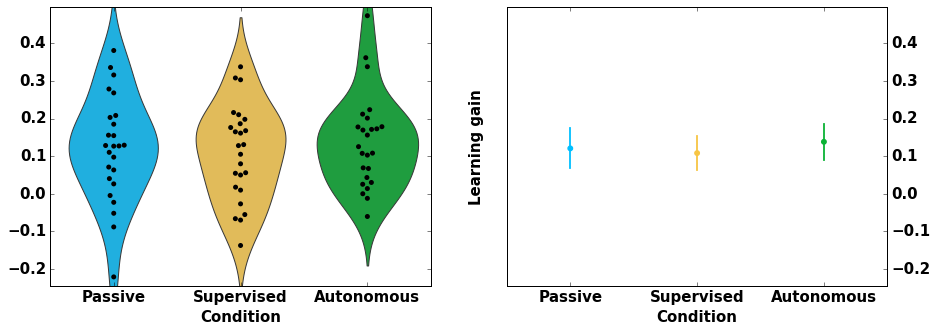

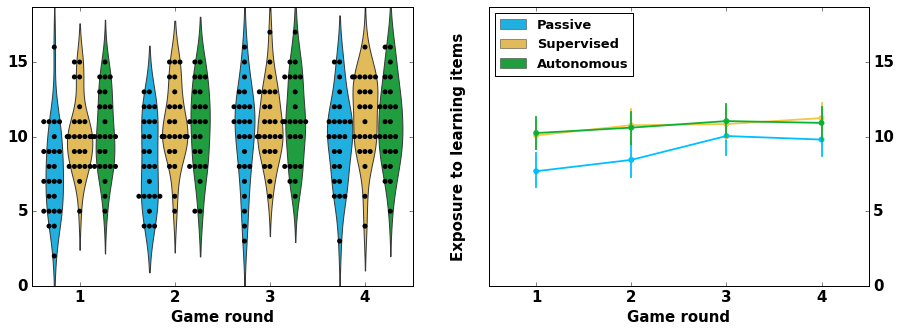

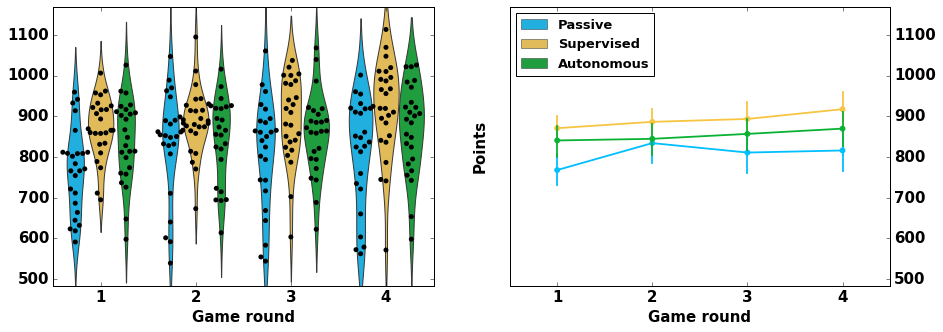

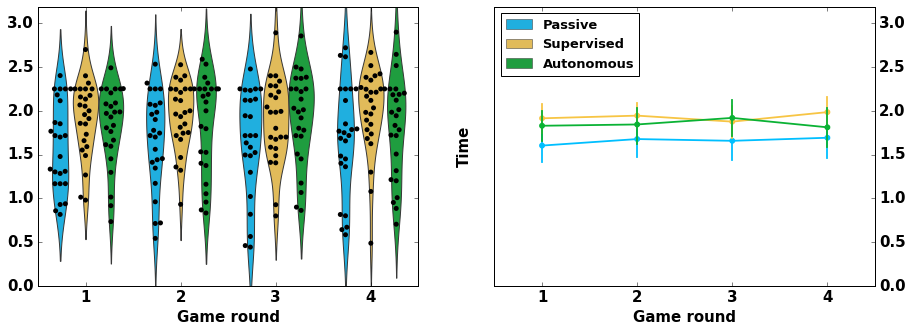

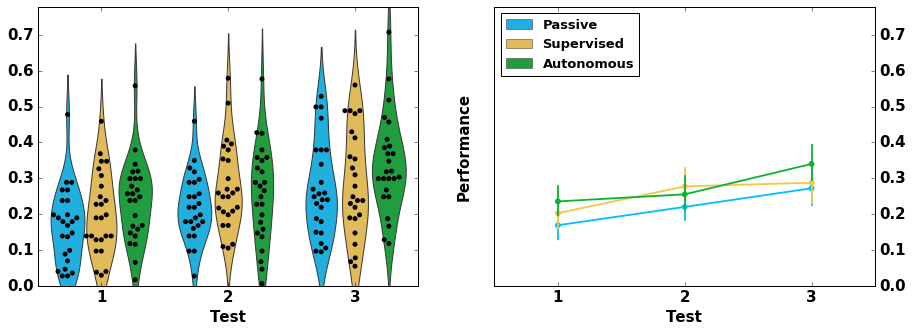

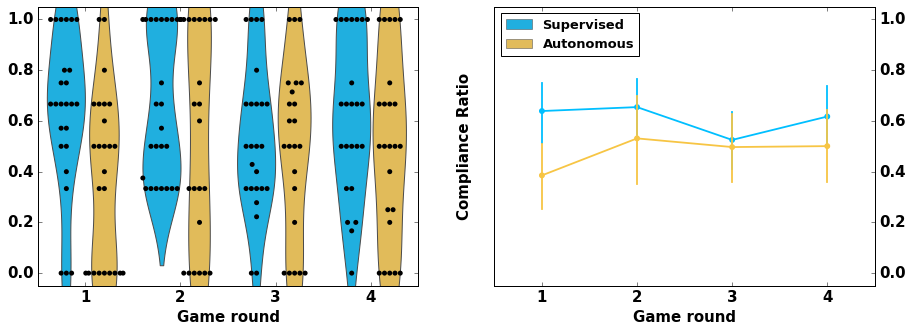

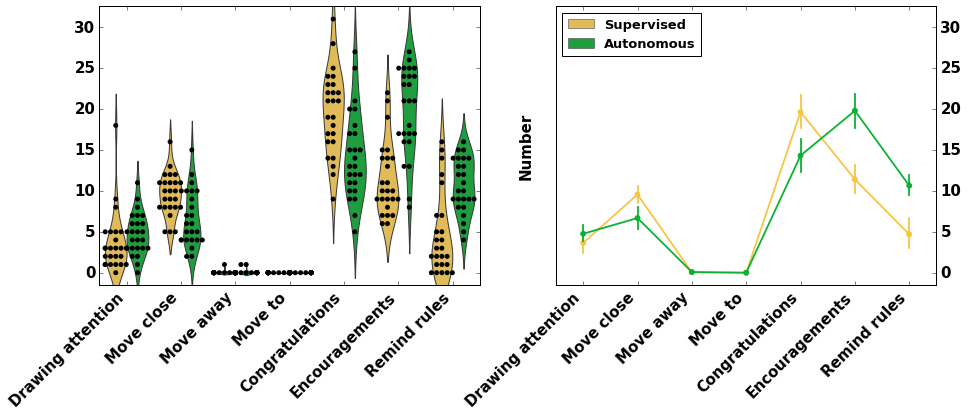

In [16]:
saving=True
sub_frame = df.loc[(df["condition"]=="Supervised") | (df["condition"]=="Autonomous")]
analyse_single(df,"condition","learning","Condition","Learning gain", saving=saving)
analyse(df,"Game","d_eat","condition","Game round","Exposure to learning items",saving=True)
analyse(df,"Game","points","condition","Game round","Points", saving=saving)
analyse(df,"Game","time","condition","Game round","Time", saving=saving)
analyse(df,"test","perf","condition","Test","Performance", saving=saving)
analyse(sub_frame,"Game","compliance_ratio","condition","Game round","Compliance Ratio", saving=True)
saving=False
action_categories=["att","mvc","mva", "mvt", "congrats", "encour", "rul"]
action_labels=["Drawing attention","Move close", "Move away", "Move to", "Congratulations", "Encouragements","Remind rules"]
analyse_actions(sub_frame,action_categories,"condition","","Number",action_labels,saving=saving)

In [12]:
#Demographics
#Age
print "Age: "+str(np.mean(df["age"])) +" ("+str(round(np.std(df["age"]),2))+")"
print str(np.sum(df["gender"]=="female"))+"F/"+str(np.sum(df["gender"]=="male"))+"M"

Age: 9.4 (0.71)
37F/38M


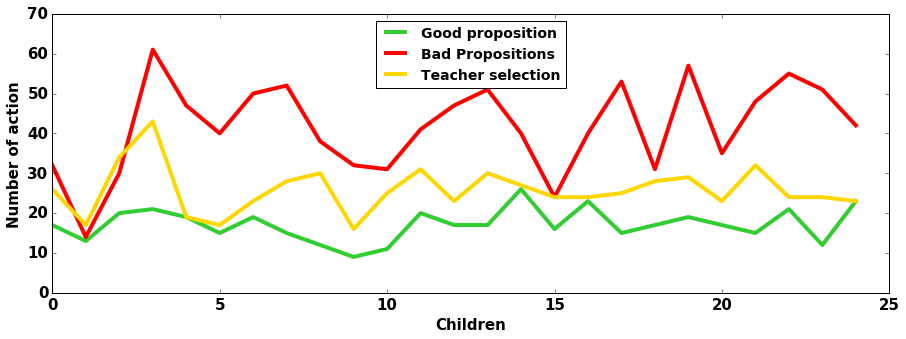

In [15]:
#Supervisor
with open("supervisor.json",'r') as f:
    d=json.load(f)
ratio=[]
ratio_accepted=[]
ratio_canceled=[]
good_sug=[]
total_sel=[]
n_proposed=np.zeros(len(d))
n_skip=np.zeros(len(d))
n_press=np.zeros(len(d))
n_autoexe=np.zeros(len(d))
n_enforced=np.zeros(len(d))
n_doit=np.zeros(len(d))
n_select=np.zeros(len(d))
n_reenforced=np.zeros(len(d))
n_cancel=np.zeros(len(d))
n_remove=np.zeros(len(d))

for i, a in enumerate(d):
    n_proposed[i]=len(a["proposed"])
    n_skip[i]=len(a["skip"])
    n_press[i]=len(a["press"])
    n_autoexe[i]=len(a["autoexe"])
    n_enforced[i]=len(a["enforced"])
    n_reenforced[i]=len(a["reenforced"])
    n_doit[i]=len(a["doit"])
    n_select[i]=len(a["select"])
    n_cancel[i]=len(a["cancel"])
    n_remove[i]=len(a["remove"])
    
saving=True
f=plt.figure(figsize=(15,5))
n_good=n_autoexe+n_enforced+n_doit+n_reenforced
n_bad=n_cancel + n_remove + n_skip - n_reenforced
n_teacher = n_select - n_reenforced - n_enforced
n_good_child=np.zeros(len(n_good)/4)
n_bad_child=np.zeros(len(n_bad)/4)
n_teacher_child=np.zeros(len(n_teacher)/4)
for i in range(len(n_good_child)):
    n_good_child[i]=n_good[4*i]+n_good[4*i+1]+n_good[4*i+2]+n_good[4*i+3]
    n_bad_child[i]=n_bad[4*i]+n_bad[4*i+1]+n_bad[4*i+2]+n_bad[4*i+3]
    n_teacher_child[i]=n_teacher[4*i]+n_teacher[4*i+1]+n_teacher[4*i+2]+n_teacher[4*i+3]

plt.plot(n_good_child,'limegreen',linewidth=4, label="Good proposition")
plt.plot(n_bad_child,'r',linewidth=4, label="Bad Propositions")
plt.plot(n_teacher_child,'gold',linewidth=4, label="Teacher selection")
plt.ylabel("Number of action",**font)
plt.xlabel("Children",**font)
plt.legend(prop={'size': 14}, loc="upper center")

#Add stats

if saving:
    f.savefig(path+"summary_supervision.pdf",bbox_inches="tight")
plt.show()

Supervised


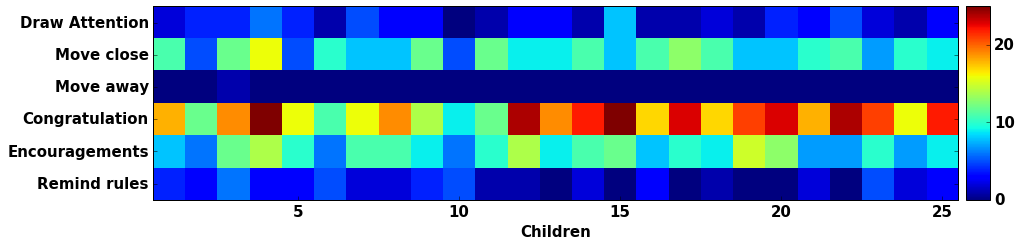

Autonomous


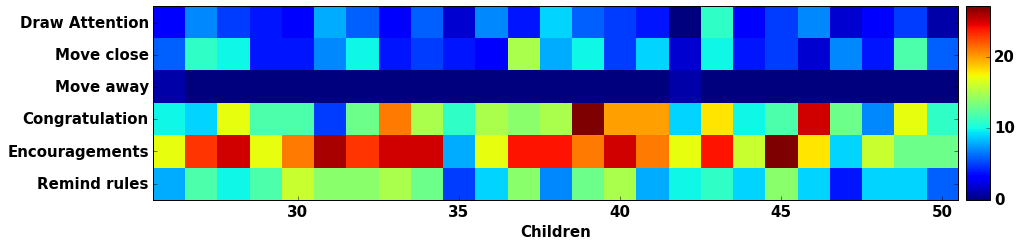

In [5]:
with open("supervised.json",'r') as f:
    json_supervised=json.load(f)
with open("autonomous.json",'r') as f:
    json_autonomous=json.load(f)
actions_supervised=[]
actions_autonomous=[]
for sess in json_supervised:
    a={}
    for k in sess:
        a[int(k)]=sess[k]
    actions_supervised.append(a)
for sess in json_autonomous:
    a={}
    for k in sess:
        a[int(k)]=sess[k]
    actions_autonomous.append(a)
    
action_labels=['att_eagle', 'att_wolf', 'att_mouse', 'att_snake', 'att_bird', 'att_frog', 'att_dragonfly', 'att_fly', 'att_butterfly', 'att_grasshopper', 'att_flower-1', 'att_flower-2', 'att_flower-3', 'att_apple-1', 'att_apple-2', 'att_apple-3', 'att_apple-4', 'att_wheat-1', 'att_wheat-2', 'att_wheat-3', 'att_wheat-4', 'mvt_eagle_eagle', 'mvt_eagle_wolf', 'mvt_eagle_mouse', 'mvt_eagle_snake', 'mvt_eagle_bird', 'mvt_eagle_frog', 'mvt_eagle_dragonfly', 'mvt_eagle_fly', 'mvt_eagle_butterfly', 'mvt_eagle_grasshopper', 'mvt_eagle_flower-1', 'mvt_eagle_flower-2', 'mvt_eagle_flower-3', 'mvt_eagle_apple-1', 'mvt_eagle_apple-2', 'mvt_eagle_apple-3', 'mvt_eagle_apple-4', 'mvt_eagle_wheat-1', 'mvt_eagle_wheat-2', 'mvt_eagle_wheat-3', 'mvt_eagle_wheat-4', 'mvc_eagle_eagle', 'mvc_eagle_wolf', 'mvc_eagle_mouse', 'mvc_eagle_snake', 'mvc_eagle_bird', 'mvc_eagle_frog', 'mvc_eagle_dragonfly', 'mvc_eagle_fly', 'mvc_eagle_butterfly', 'mvc_eagle_grasshopper', 'mvc_eagle_flower-1', 'mvc_eagle_flower-2', 'mvc_eagle_flower-3', 'mvc_eagle_apple-1', 'mvc_eagle_apple-2', 'mvc_eagle_apple-3', 'mvc_eagle_apple-4', 'mvc_eagle_wheat-1', 'mvc_eagle_wheat-2', 'mvc_eagle_wheat-3', 'mvc_eagle_wheat-4', 'mva_eagle_eagle', 'mva_eagle_wolf', 'mva_eagle_mouse', 'mva_eagle_snake', 'mva_eagle_bird', 'mva_eagle_frog', 'mva_eagle_dragonfly', 'mva_eagle_fly', 'mva_eagle_butterfly', 'mva_eagle_grasshopper', 'mva_eagle_flower-1', 'mva_eagle_flower-2', 'mva_eagle_flower-3', 'mva_eagle_apple-1', 'mva_eagle_apple-2', 'mva_eagle_apple-3', 'mva_eagle_apple-4', 'mva_eagle_wheat-1', 'mva_eagle_wheat-2', 'mva_eagle_wheat-3', 'mva_eagle_wheat-4', 'mvt_wolf_eagle', 'mvt_wolf_wolf', 'mvt_wolf_mouse', 'mvt_wolf_snake', 'mvt_wolf_bird', 'mvt_wolf_frog', 'mvt_wolf_dragonfly', 'mvt_wolf_fly', 'mvt_wolf_butterfly', 'mvt_wolf_grasshopper', 'mvt_wolf_flower-1', 'mvt_wolf_flower-2', 'mvt_wolf_flower-3', 'mvt_wolf_apple-1', 'mvt_wolf_apple-2', 'mvt_wolf_apple-3', 'mvt_wolf_apple-4', 'mvt_wolf_wheat-1', 'mvt_wolf_wheat-2', 'mvt_wolf_wheat-3', 'mvt_wolf_wheat-4', 'mvc_wolf_eagle', 'mvc_wolf_wolf', 'mvc_wolf_mouse', 'mvc_wolf_snake', 'mvc_wolf_bird', 'mvc_wolf_frog', 'mvc_wolf_dragonfly', 'mvc_wolf_fly', 'mvc_wolf_butterfly', 'mvc_wolf_grasshopper', 'mvc_wolf_flower-1', 'mvc_wolf_flower-2', 'mvc_wolf_flower-3', 'mvc_wolf_apple-1', 'mvc_wolf_apple-2', 'mvc_wolf_apple-3', 'mvc_wolf_apple-4', 'mvc_wolf_wheat-1', 'mvc_wolf_wheat-2', 'mvc_wolf_wheat-3', 'mvc_wolf_wheat-4', 'mva_wolf_eagle', 'mva_wolf_wolf', 'mva_wolf_mouse', 'mva_wolf_snake', 'mva_wolf_bird', 'mva_wolf_frog', 'mva_wolf_dragonfly', 'mva_wolf_fly', 'mva_wolf_butterfly', 'mva_wolf_grasshopper', 'mva_wolf_flower-1', 'mva_wolf_flower-2', 'mva_wolf_flower-3', 'mva_wolf_apple-1', 'mva_wolf_apple-2', 'mva_wolf_apple-3', 'mva_wolf_apple-4', 'mva_wolf_wheat-1', 'mva_wolf_wheat-2', 'mva_wolf_wheat-3', 'mva_wolf_wheat-4', 'mvt_mouse_eagle', 'mvt_mouse_wolf', 'mvt_mouse_mouse', 'mvt_mouse_snake', 'mvt_mouse_bird', 'mvt_mouse_frog', 'mvt_mouse_dragonfly', 'mvt_mouse_fly', 'mvt_mouse_butterfly', 'mvt_mouse_grasshopper', 'mvt_mouse_flower-1', 'mvt_mouse_flower-2', 'mvt_mouse_flower-3', 'mvt_mouse_apple-1', 'mvt_mouse_apple-2', 'mvt_mouse_apple-3', 'mvt_mouse_apple-4', 'mvt_mouse_wheat-1', 'mvt_mouse_wheat-2', 'mvt_mouse_wheat-3', 'mvt_mouse_wheat-4', 'mvc_mouse_eagle', 'mvc_mouse_wolf', 'mvc_mouse_mouse', 'mvc_mouse_snake', 'mvc_mouse_bird', 'mvc_mouse_frog', 'mvc_mouse_dragonfly', 'mvc_mouse_fly', 'mvc_mouse_butterfly', 'mvc_mouse_grasshopper', 'mvc_mouse_flower-1', 'mvc_mouse_flower-2', 'mvc_mouse_flower-3', 'mvc_mouse_apple-1', 'mvc_mouse_apple-2', 'mvc_mouse_apple-3', 'mvc_mouse_apple-4', 'mvc_mouse_wheat-1', 'mvc_mouse_wheat-2', 'mvc_mouse_wheat-3', 'mvc_mouse_wheat-4', 'mva_mouse_eagle', 'mva_mouse_wolf', 'mva_mouse_mouse', 'mva_mouse_snake', 'mva_mouse_bird', 'mva_mouse_frog', 'mva_mouse_dragonfly', 'mva_mouse_fly', 'mva_mouse_butterfly', 'mva_mouse_grasshopper', 'mva_mouse_flower-1', 'mva_mouse_flower-2', 'mva_mouse_flower-3', 'mva_mouse_apple-1', 'mva_mouse_apple-2', 'mva_mouse_apple-3', 'mva_mouse_apple-4', 'mva_mouse_wheat-1', 'mva_mouse_wheat-2', 'mva_mouse_wheat-3', 'mva_mouse_wheat-4', 'mvt_snake_eagle', 'mvt_snake_wolf', 'mvt_snake_mouse', 'mvt_snake_snake', 'mvt_snake_bird', 'mvt_snake_frog', 'mvt_snake_dragonfly', 'mvt_snake_fly', 'mvt_snake_butterfly', 'mvt_snake_grasshopper', 'mvt_snake_flower-1', 'mvt_snake_flower-2', 'mvt_snake_flower-3', 'mvt_snake_apple-1', 'mvt_snake_apple-2', 'mvt_snake_apple-3', 'mvt_snake_apple-4', 'mvt_snake_wheat-1', 'mvt_snake_wheat-2', 'mvt_snake_wheat-3', 'mvt_snake_wheat-4', 'mvc_snake_eagle', 'mvc_snake_wolf', 'mvc_snake_mouse', 'mvc_snake_snake', 'mvc_snake_bird', 'mvc_snake_frog', 'mvc_snake_dragonfly', 'mvc_snake_fly', 'mvc_snake_butterfly', 'mvc_snake_grasshopper', 'mvc_snake_flower-1', 'mvc_snake_flower-2', 'mvc_snake_flower-3', 'mvc_snake_apple-1', 'mvc_snake_apple-2', 'mvc_snake_apple-3', 'mvc_snake_apple-4', 'mvc_snake_wheat-1', 'mvc_snake_wheat-2', 'mvc_snake_wheat-3', 'mvc_snake_wheat-4', 'mva_snake_eagle', 'mva_snake_wolf', 'mva_snake_mouse', 'mva_snake_snake', 'mva_snake_bird', 'mva_snake_frog', 'mva_snake_dragonfly', 'mva_snake_fly', 'mva_snake_butterfly', 'mva_snake_grasshopper', 'mva_snake_flower-1', 'mva_snake_flower-2', 'mva_snake_flower-3', 'mva_snake_apple-1', 'mva_snake_apple-2', 'mva_snake_apple-3', 'mva_snake_apple-4', 'mva_snake_wheat-1', 'mva_snake_wheat-2', 'mva_snake_wheat-3', 'mva_snake_wheat-4', 'mvt_bird_eagle', 'mvt_bird_wolf', 'mvt_bird_mouse', 'mvt_bird_snake', 'mvt_bird_bird', 'mvt_bird_frog', 'mvt_bird_dragonfly', 'mvt_bird_fly', 'mvt_bird_butterfly', 'mvt_bird_grasshopper', 'mvt_bird_flower-1', 'mvt_bird_flower-2', 'mvt_bird_flower-3', 'mvt_bird_apple-1', 'mvt_bird_apple-2', 'mvt_bird_apple-3', 'mvt_bird_apple-4', 'mvt_bird_wheat-1', 'mvt_bird_wheat-2', 'mvt_bird_wheat-3', 'mvt_bird_wheat-4', 'mvc_bird_eagle', 'mvc_bird_wolf', 'mvc_bird_mouse', 'mvc_bird_snake', 'mvc_bird_bird', 'mvc_bird_frog', 'mvc_bird_dragonfly', 'mvc_bird_fly', 'mvc_bird_butterfly', 'mvc_bird_grasshopper', 'mvc_bird_flower-1', 'mvc_bird_flower-2', 'mvc_bird_flower-3', 'mvc_bird_apple-1', 'mvc_bird_apple-2', 'mvc_bird_apple-3', 'mvc_bird_apple-4', 'mvc_bird_wheat-1', 'mvc_bird_wheat-2', 'mvc_bird_wheat-3', 'mvc_bird_wheat-4', 'mva_bird_eagle', 'mva_bird_wolf', 'mva_bird_mouse', 'mva_bird_snake', 'mva_bird_bird', 'mva_bird_frog', 'mva_bird_dragonfly', 'mva_bird_fly', 'mva_bird_butterfly', 'mva_bird_grasshopper', 'mva_bird_flower-1', 'mva_bird_flower-2', 'mva_bird_flower-3', 'mva_bird_apple-1', 'mva_bird_apple-2', 'mva_bird_apple-3', 'mva_bird_apple-4', 'mva_bird_wheat-1', 'mva_bird_wheat-2', 'mva_bird_wheat-3', 'mva_bird_wheat-4', 'mvt_frog_eagle', 'mvt_frog_wolf', 'mvt_frog_mouse', 'mvt_frog_snake', 'mvt_frog_bird', 'mvt_frog_frog', 'mvt_frog_dragonfly', 'mvt_frog_fly', 'mvt_frog_butterfly', 'mvt_frog_grasshopper', 'mvt_frog_flower-1', 'mvt_frog_flower-2', 'mvt_frog_flower-3', 'mvt_frog_apple-1', 'mvt_frog_apple-2', 'mvt_frog_apple-3', 'mvt_frog_apple-4', 'mvt_frog_wheat-1', 'mvt_frog_wheat-2', 'mvt_frog_wheat-3', 'mvt_frog_wheat-4', 'mvc_frog_eagle', 'mvc_frog_wolf', 'mvc_frog_mouse', 'mvc_frog_snake', 'mvc_frog_bird', 'mvc_frog_frog', 'mvc_frog_dragonfly', 'mvc_frog_fly', 'mvc_frog_butterfly', 'mvc_frog_grasshopper', 'mvc_frog_flower-1', 'mvc_frog_flower-2', 'mvc_frog_flower-3', 'mvc_frog_apple-1', 'mvc_frog_apple-2', 'mvc_frog_apple-3', 'mvc_frog_apple-4', 'mvc_frog_wheat-1', 'mvc_frog_wheat-2', 'mvc_frog_wheat-3', 'mvc_frog_wheat-4', 'mva_frog_eagle', 'mva_frog_wolf', 'mva_frog_mouse', 'mva_frog_snake', 'mva_frog_bird', 'mva_frog_frog', 'mva_frog_dragonfly', 'mva_frog_fly', 'mva_frog_butterfly', 'mva_frog_grasshopper', 'mva_frog_flower-1', 'mva_frog_flower-2', 'mva_frog_flower-3', 'mva_frog_apple-1', 'mva_frog_apple-2', 'mva_frog_apple-3', 'mva_frog_apple-4', 'mva_frog_wheat-1', 'mva_frog_wheat-2', 'mva_frog_wheat-3', 'mva_frog_wheat-4', 'mvt_dragonfly_eagle', 'mvt_dragonfly_wolf', 'mvt_dragonfly_mouse', 'mvt_dragonfly_snake', 'mvt_dragonfly_bird', 'mvt_dragonfly_frog', 'mvt_dragonfly_dragonfly', 'mvt_dragonfly_fly', 'mvt_dragonfly_butterfly', 'mvt_dragonfly_grasshopper', 'mvt_dragonfly_flower-1', 'mvt_dragonfly_flower-2', 'mvt_dragonfly_flower-3', 'mvt_dragonfly_apple-1', 'mvt_dragonfly_apple-2', 'mvt_dragonfly_apple-3', 'mvt_dragonfly_apple-4', 'mvt_dragonfly_wheat-1', 'mvt_dragonfly_wheat-2', 'mvt_dragonfly_wheat-3', 'mvt_dragonfly_wheat-4', 'mvc_dragonfly_eagle', 'mvc_dragonfly_wolf', 'mvc_dragonfly_mouse', 'mvc_dragonfly_snake', 'mvc_dragonfly_bird', 'mvc_dragonfly_frog', 'mvc_dragonfly_dragonfly', 'mvc_dragonfly_fly', 'mvc_dragonfly_butterfly', 'mvc_dragonfly_grasshopper', 'mvc_dragonfly_flower-1', 'mvc_dragonfly_flower-2', 'mvc_dragonfly_flower-3', 'mvc_dragonfly_apple-1', 'mvc_dragonfly_apple-2', 'mvc_dragonfly_apple-3', 'mvc_dragonfly_apple-4', 'mvc_dragonfly_wheat-1', 'mvc_dragonfly_wheat-2', 'mvc_dragonfly_wheat-3', 'mvc_dragonfly_wheat-4', 'mva_dragonfly_eagle', 'mva_dragonfly_wolf', 'mva_dragonfly_mouse', 'mva_dragonfly_snake', 'mva_dragonfly_bird', 'mva_dragonfly_frog', 'mva_dragonfly_dragonfly', 'mva_dragonfly_fly', 'mva_dragonfly_butterfly', 'mva_dragonfly_grasshopper', 'mva_dragonfly_flower-1', 'mva_dragonfly_flower-2', 'mva_dragonfly_flower-3', 'mva_dragonfly_apple-1', 'mva_dragonfly_apple-2', 'mva_dragonfly_apple-3', 'mva_dragonfly_apple-4', 'mva_dragonfly_wheat-1', 'mva_dragonfly_wheat-2', 'mva_dragonfly_wheat-3', 'mva_dragonfly_wheat-4', 'mvt_fly_eagle', 'mvt_fly_wolf', 'mvt_fly_mouse', 'mvt_fly_snake', 'mvt_fly_bird', 'mvt_fly_frog', 'mvt_fly_dragonfly', 'mvt_fly_fly', 'mvt_fly_butterfly', 'mvt_fly_grasshopper', 'mvt_fly_flower-1', 'mvt_fly_flower-2', 'mvt_fly_flower-3', 'mvt_fly_apple-1', 'mvt_fly_apple-2', 'mvt_fly_apple-3', 'mvt_fly_apple-4', 'mvt_fly_wheat-1', 'mvt_fly_wheat-2', 'mvt_fly_wheat-3', 'mvt_fly_wheat-4', 'mvc_fly_eagle', 'mvc_fly_wolf', 'mvc_fly_mouse', 'mvc_fly_snake', 'mvc_fly_bird', 'mvc_fly_frog', 'mvc_fly_dragonfly', 'mvc_fly_fly', 'mvc_fly_butterfly', 'mvc_fly_grasshopper', 'mvc_fly_flower-1', 'mvc_fly_flower-2', 'mvc_fly_flower-3', 'mvc_fly_apple-1', 'mvc_fly_apple-2', 'mvc_fly_apple-3', 'mvc_fly_apple-4', 'mvc_fly_wheat-1', 'mvc_fly_wheat-2', 'mvc_fly_wheat-3', 'mvc_fly_wheat-4', 'mva_fly_eagle', 'mva_fly_wolf', 'mva_fly_mouse', 'mva_fly_snake', 'mva_fly_bird', 'mva_fly_frog', 'mva_fly_dragonfly', 'mva_fly_fly', 'mva_fly_butterfly', 'mva_fly_grasshopper', 'mva_fly_flower-1', 'mva_fly_flower-2', 'mva_fly_flower-3', 'mva_fly_apple-1', 'mva_fly_apple-2', 'mva_fly_apple-3', 'mva_fly_apple-4', 'mva_fly_wheat-1', 'mva_fly_wheat-2', 'mva_fly_wheat-3', 'mva_fly_wheat-4', 'mvt_butterfly_eagle', 'mvt_butterfly_wolf', 'mvt_butterfly_mouse', 'mvt_butterfly_snake', 'mvt_butterfly_bird', 'mvt_butterfly_frog', 'mvt_butterfly_dragonfly', 'mvt_butterfly_fly', 'mvt_butterfly_butterfly', 'mvt_butterfly_grasshopper', 'mvt_butterfly_flower-1', 'mvt_butterfly_flower-2', 'mvt_butterfly_flower-3', 'mvt_butterfly_apple-1', 'mvt_butterfly_apple-2', 'mvt_butterfly_apple-3', 'mvt_butterfly_apple-4', 'mvt_butterfly_wheat-1', 'mvt_butterfly_wheat-2', 'mvt_butterfly_wheat-3', 'mvt_butterfly_wheat-4', 'mvc_butterfly_eagle', 'mvc_butterfly_wolf', 'mvc_butterfly_mouse', 'mvc_butterfly_snake', 'mvc_butterfly_bird', 'mvc_butterfly_frog', 'mvc_butterfly_dragonfly', 'mvc_butterfly_fly', 'mvc_butterfly_butterfly', 'mvc_butterfly_grasshopper', 'mvc_butterfly_flower-1', 'mvc_butterfly_flower-2', 'mvc_butterfly_flower-3', 'mvc_butterfly_apple-1', 'mvc_butterfly_apple-2', 'mvc_butterfly_apple-3', 'mvc_butterfly_apple-4', 'mvc_butterfly_wheat-1', 'mvc_butterfly_wheat-2', 'mvc_butterfly_wheat-3', 'mvc_butterfly_wheat-4', 'mva_butterfly_eagle', 'mva_butterfly_wolf', 'mva_butterfly_mouse', 'mva_butterfly_snake', 'mva_butterfly_bird', 'mva_butterfly_frog', 'mva_butterfly_dragonfly', 'mva_butterfly_fly', 'mva_butterfly_butterfly', 'mva_butterfly_grasshopper', 'mva_butterfly_flower-1', 'mva_butterfly_flower-2', 'mva_butterfly_flower-3', 'mva_butterfly_apple-1', 'mva_butterfly_apple-2', 'mva_butterfly_apple-3', 'mva_butterfly_apple-4', 'mva_butterfly_wheat-1', 'mva_butterfly_wheat-2', 'mva_butterfly_wheat-3', 'mva_butterfly_wheat-4', 'mvt_grasshopper_eagle', 'mvt_grasshopper_wolf', 'mvt_grasshopper_mouse', 'mvt_grasshopper_snake', 'mvt_grasshopper_bird', 'mvt_grasshopper_frog', 'mvt_grasshopper_dragonfly', 'mvt_grasshopper_fly', 'mvt_grasshopper_butterfly', 'mvt_grasshopper_grasshopper', 'mvt_grasshopper_flower-1', 'mvt_grasshopper_flower-2', 'mvt_grasshopper_flower-3', 'mvt_grasshopper_apple-1', 'mvt_grasshopper_apple-2', 'mvt_grasshopper_apple-3', 'mvt_grasshopper_apple-4', 'mvt_grasshopper_wheat-1', 'mvt_grasshopper_wheat-2', 'mvt_grasshopper_wheat-3', 'mvt_grasshopper_wheat-4', 'mvc_grasshopper_eagle', 'mvc_grasshopper_wolf', 'mvc_grasshopper_mouse', 'mvc_grasshopper_snake', 'mvc_grasshopper_bird', 'mvc_grasshopper_frog', 'mvc_grasshopper_dragonfly', 'mvc_grasshopper_fly', 'mvc_grasshopper_butterfly', 'mvc_grasshopper_grasshopper', 'mvc_grasshopper_flower-1', 'mvc_grasshopper_flower-2', 'mvc_grasshopper_flower-3', 'mvc_grasshopper_apple-1', 'mvc_grasshopper_apple-2', 'mvc_grasshopper_apple-3', 'mvc_grasshopper_apple-4', 'mvc_grasshopper_wheat-1', 'mvc_grasshopper_wheat-2', 'mvc_grasshopper_wheat-3', 'mvc_grasshopper_wheat-4', 'mva_grasshopper_eagle', 'mva_grasshopper_wolf', 'mva_grasshopper_mouse', 'mva_grasshopper_snake', 'mva_grasshopper_bird', 'mva_grasshopper_frog', 'mva_grasshopper_dragonfly', 'mva_grasshopper_fly', 'mva_grasshopper_butterfly', 'mva_grasshopper_grasshopper', 'mva_grasshopper_flower-1', 'mva_grasshopper_flower-2', 'mva_grasshopper_flower-3', 'mva_grasshopper_apple-1', 'mva_grasshopper_apple-2', 'mva_grasshopper_apple-3', 'mva_grasshopper_apple-4', 'mva_grasshopper_wheat-1', 'mva_grasshopper_wheat-2', 'mva_grasshopper_wheat-3', 'mva_grasshopper_wheat-4', 'congrats', 'encour', 'rul', 'wait']
def get_matrix(actions):
    ind_action_labels=[]
    ind_actions=[]
    for a in actions:
        for key in a.keys():
            if key not in ind_actions:
                ind_actions.append(key)
    ind_actions.sort()
    for i,a in enumerate(ind_actions):
        l = action_labels[a].split("_")[0]
        if l not in ind_action_labels and l is not "wait":
            ind_action_labels.append(l)
            
    executed_actions = np.zeros((len(ind_action_labels),len(actions)))
    for i,a in enumerate(actions):
        for key in a.keys():
            for ind,l in enumerate(ind_action_labels):
                if action_labels[key].startswith(l):
                    executed_actions[ind,i]+=a[key]
    return ind_action_labels,executed_actions

def get_action(actions,name,saving=True, letters=False):
    l,m=get_matrix(actions)
    f, ax1 = plt.subplots(figsize=(15,5))
    cax=ax1.matshow(m)
    labels = ["Draw Attention", "Move close", "Move away","Congratulation","Encouragements","Remind rules"]
    plt.yticks(np.arange(len(l)), labels)
    
    plt.gca().xaxis.tick_bottom()
    plt.xticks([4,9,14,19,24], [5,10,15,20,25])
    if letters:
        plt.xticks([4,9,14,19,24], [30,35,40,45,50])
    #plt.title(title)
    plt.xlabel("Children",**font)
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="3%", pad=0.1)
    cbar=f.colorbar(cax, cax=cax1)
    cbar.set_ticks([0,10,20])
    cbar.ax.set_yticklabels([0, 10,20]) 
    plt.show()
    if saving:
        f.savefig(path+name+"_actions.pdf",bbox_inches="tight")
print "Supervised"
get_action(actions_supervised,"supervised",saving=saving)
print "Autonomous"
get_action(actions_autonomous,"autonomous",saving=saving,letters=True)

In [20]:
labels = ["Draw Attention", "Move close", "Move away","Congratulation","Encouragements","Remind rules"]
l,m=get_matrix(actions_supervised)
len(m)
to_print="Supervised"
for v in m:
    to_print += " & "+str(round(np.mean(v),1))+" ("+str(round(np.std(v),1))+")"
to_print +="\\\\"
print to_print
l,m=get_matrix(actions_autonomous)
len(m)
to_print="Autonomous"
for v in m:
    to_print += " & "+str(round(np.mean(v),1))+" ("+str(round(np.std(v),1))+")"
to_print +="\\\\"
print to_print
#print np.mean(m,axis=1)
#print np.std(m,axis=1)




Supervised & 2.8 (1.8) & 9.6 (2.6) & 0.0 (0.2) & 18.5 (4.5) & 9.8 (2.5) & 2.3 (1.8)\\
Autonomous & 4.8 (2.5) & 6.7 (3.3) & 0.1 (0.3) & 14.3 (5.3) & 19.8 (5.2) & 10.6 (3.3)\\


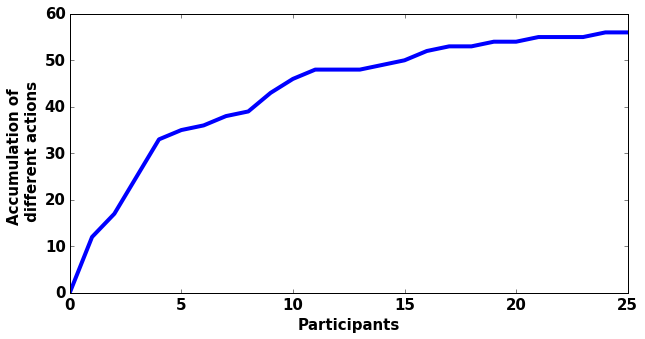

In [16]:
with open("different_actions.json",'r') as f:
    actions=json.load(f)

f=plt.figure(figsize=(10,5))
plt.plot(actions,linewidth=4)
plt.ylabel("Accumulation of \n different actions",**font)
plt.xlabel("Participants",**font)
plt.show()

if saving:
    f.savefig(path+"number_actions.pdf",bbox_inches="tight")

In [25]:
a=np.zeros((2,2,2))
print a
a[1]=np.ones((2,2))
print a

[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
[[[0. 0.]
  [0. 0.]]

 [[1. 1.]
  [1. 1.]]]


In [23]:
a="ablifds"
a[:3]

'abl'